In [1]:
!pip install nltk torch tqdm transformers pandas numpy datetime matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 10.9 MB/s eta 0:00:00


In [2]:
# sentiment_price_pipeline.py
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
tqdm.pandas()  #tqdm is fast, extensible progress bar for python loops

In [5]:
news_csv_path = "/content/nvidia_financial_news (1).csv"
nvidia_news_data = pd.read_csv(news_csv_path)

In [7]:
nvidia_news_data.dtypes

,0
source,object
author,object
title,object
description,object
url,object
urlToImage,object
publishedAt,object
content,object


In [9]:
cols_keep = []
for c in ["publishedAt", "published_at", "date", "title", "description", "content", "url", "source"]:
    if c in nvidia_news_data.columns:
        cols_keep.append(c)
nvidia_news_data = nvidia_news_data[cols_keep].copy()

In [11]:
nvidia_news_data.dtypes

,0
publishedAt,object
title,object
description,object
content,object
url,object
source,object


In [12]:
nvidia_news_data['publishedAt'] = pd.to_datetime(nvidia_news_data['publishedAt'])

In [13]:
# create a text column containing title and description
nvidia_news_data["text"] = nvidia_news_data.get("title", "").fillna("") + ". " + nvidia_news_data.get("description", "").fillna("")


In [14]:
from transformers import pipeline

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model = "ProsusAI/finbert",
    truncation = True,
)

#Function to get sentiment from finbert
def get_finbert_sentiment(text):
        result = sentiment_analyzer(text[:512])[0]  # Limit text to 512 tokens
        label = result['label']
        score = result['score']

        # Convert label to numeric for easier analysis
        if label == "positive":
            sentiment_value = 1
        elif label == "negative":
            sentiment_value = -1
        else:
            sentiment_value = 0

        return pd.Series([label, sentiment_value, score])

#Apply sentiment analysis
tqdm.pandas(desc="Calculating FinBERT Sentiment")
nvidia_news_data[['sentiment_label', 'sentiment_score', 'confidence']] = nvidia_news_data['text'].progress_apply(get_finbert_sentiment)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Calculating FinBERT Sentiment:   0%|          | 0/70 [00:00<?, ?it/s]

In [21]:
nvidia_news_data.dtypes


,0
publishedAt,"datetime64[ns, UTC]"
title,object
description,object
content,object
url,object
source,object
text,object
sentiment_label,object
sentiment_score,int64
confidence,float64


In [16]:
nvidia_news_data.to_csv("nvidia_news_with_sentiment_score.csv", index=False)

In [18]:
nvidia_news_data.shape

(70, 10)

##FinBERT sentiment scores with actual stock data to analyze how market sentiment correlates with price movement.

In [19]:
import yfinance as yf
import pandas as pd

# --- Clean Nvidia stock data ---
nvidia_stock = yf.download("NVDA", period="1mo", interval="1d")[['Close']]

# Force reset index (sometimes it doesn't drop all levels)
nvidia_stock = nvidia_stock.reset_index(drop=False)

# Ensure it's a normal DataFrame
nvidia_stock.columns = ['publishedAt', 'Close']
nvidia_stock['publishedAt'] = pd.to_datetime(nvidia_stock['publishedAt'])


/tmp/ipython-input-244877534.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvidia_stock = yf.download("NVDA", period="1mo", interval="1d")[['Close']]
[*********************100%***********************]  1 of 1 completed


In [20]:
nvidia_stock.head()

,publishedAt,Close
0,2025-10-06,185.539993
1,2025-10-07,185.039993
2,2025-10-08,189.110001
3,2025-10-09,192.570007
4,2025-10-10,183.160004


I want one sentiment score per date to merge with your stock data.

So we’ll:

Convert publishedAt → date

Group the news data by date

Average the sentiment scores per date

Merge it with stock data on date

In [24]:
import pandas as pd

# ---- Step 1: Prepare your data ----
# Ensure columns are proper datetime
nvidia_stock['date'] = pd.to_datetime(nvidia_stock['publishedAt']).dt.date
nvidia_news_data['date'] = pd.to_datetime(nvidia_news_data['publishedAt']).dt.date


In [26]:
print(nvidia_stock.dtypes)
print(nvidia_news_data.dtypes)

publishedAt    datetime64[ns]
Close                 float64
date                   object
dtype: object
publishedAt        datetime64[ns, UTC]
title                           object
description                     object
content                         object
url                             object
source                          object
text                            object
sentiment_label                 object
sentiment_score                  int64
confidence                     float64
date                            object
dtype: object


In [27]:
# ---- Step 2: Aggregate news sentiment by date ----
daily_sentiment = (
    nvidia_news_data.groupby('date')
    .agg({
        'sentiment_score': 'mean',        # Average sentiment per day
        'confidence': 'mean',             # Optional: avg confidence
        'title': 'count'                  # Number of news articles that day
    })
    .rename(columns={'title': 'article_count'})
    .reset_index()
)

# ---- Step 3: Merge with stock data ----
merged = pd.merge(nvidia_stock, daily_sentiment, on='date', how='left')

# ---- Step 4: Fill missing days with 0 sentiment (no news that day) ----
merged['sentiment_score'].fillna(0, inplace=True)
merged['confidence'].fillna(0, inplace=True)
merged['article_count'].fillna(0, inplace=True)


/tmp/ipython-input-912852479.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['sentiment_score'].fillna(0, inplace=True)
/tmp/ipython-input-912852479.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [28]:
merged

,publishedAt,Close,date,sentiment_score,confidence,article_count
0,2025-10-06,185.539993,2025-10-06,0.500000,0.919151,4.0
1,2025-10-07,185.039993,2025-10-07,-0.500000,0.929246,2.0
2,2025-10-08,189.110001,2025-10-08,-0.500000,0.807922,2.0
3,2025-10-09,192.570007,2025-10-09,0.000000,0.656341,3.0
4,2025-10-10,183.160004,2025-10-10,0.000000,0.000000,0.0
5,2025-10-13,188.320007,2025-10-13,0.166667,0.804282,6.0
6,2025-10-14,180.029999,2025-10-14,0.000000,0.862915,2.0
7,2025-10-15,179.830002,2025-10-15,0.250000,0.924721,4.0
8,2025-10-16,181.809998,2025-10-16,1.000000,0.934538,4.0
9,2025-10-17,183.220001,2025-10-17,-1.000000,0.943794,1.0


In [34]:
merged.to_csv("nvidia_sentiment_score.csv")

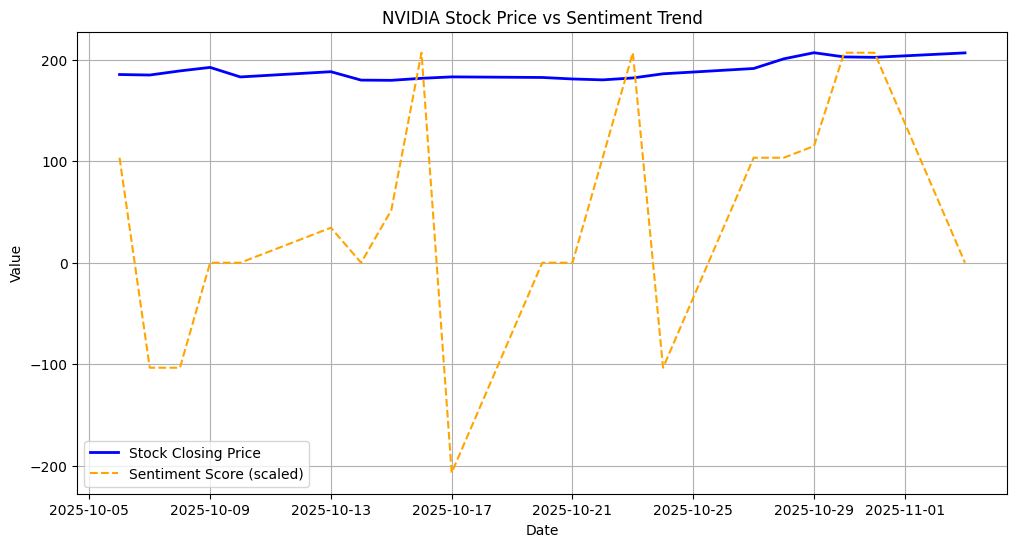

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(merged['date'], merged['Close'], label='Stock Closing Price', color='blue', linewidth=2)
plt.plot(merged['date'], merged['sentiment_score'] * merged['Close'].max(),  # scaled sentiment
         label='Sentiment Score (scaled)', color='orange', linestyle='--')
plt.title("NVIDIA Stock Price vs Sentiment Trend")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
correlation = merged['Close'].corr(merged['sentiment_score'])
print(f"Correlation between sentiment score and closing price: {correlation:.3f}")


Correlation between sentiment score and closing price: 0.294


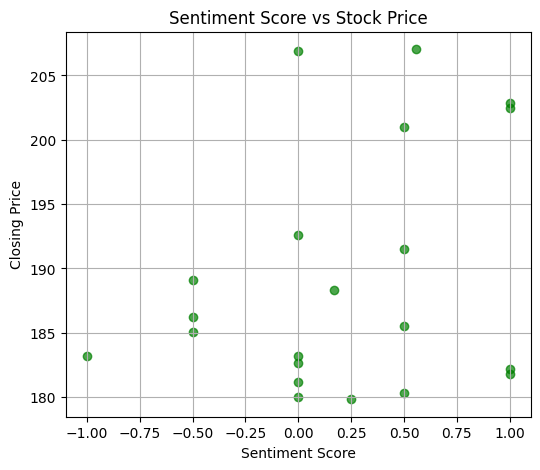

In [33]:
plt.figure(figsize=(6,5))
plt.scatter(merged['sentiment_score'], merged['Close'], color='green', alpha=0.7)
plt.title("Sentiment Score vs Stock Price")
plt.xlabel("Sentiment Score")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()


This shows visually if higher sentiment corresponds to higher stock prices.

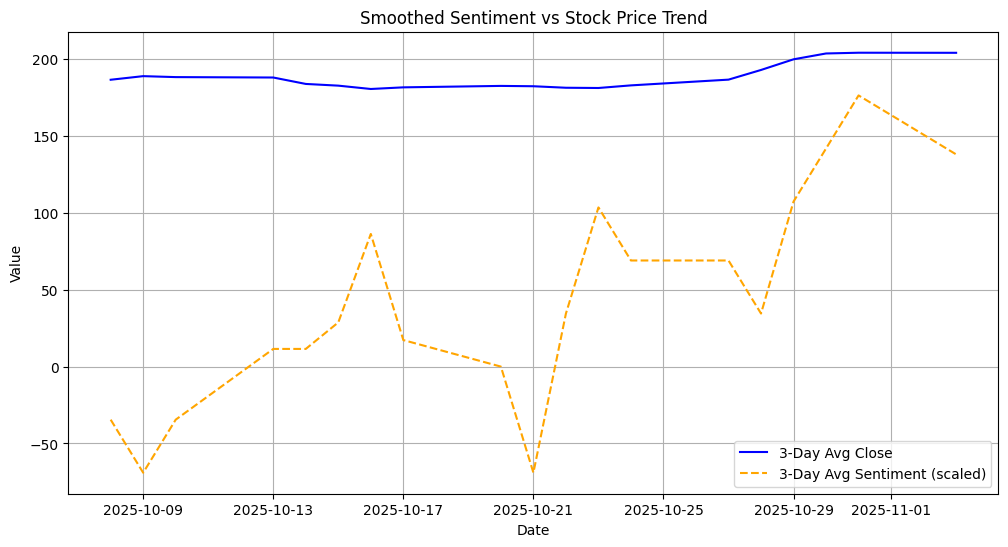

In [35]:
merged['Close_rolling'] = merged['Close'].rolling(window=3).mean()
merged['Sentiment_rolling'] = merged['sentiment_score'].rolling(window=3).mean()

plt.figure(figsize=(12,6))
plt.plot(merged['date'], merged['Close_rolling'], label='3-Day Avg Close', color='blue')
plt.plot(merged['date'], merged['Sentiment_rolling'] * merged['Close'].max(), label='3-Day Avg Sentiment (scaled)', color='orange', linestyle='--')
plt.title("Smoothed Sentiment vs Stock Price Trend")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
